In [1]:
from catboost import CatBoostClassifier
from matplotlib.pyplot import plot
from numpy import nan
from numpy import ndarray
from numpy import unique
from pandas import DataFrame
from pandas import get_dummies
from pandas import read_csv
from pandas import Series
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
train_fname = '../input/spaceship-titanic/train.csv'
train_df = read_csv(filepath_or_buffer=train_fname)

In [3]:
def get_name_count(arg) -> int:
    if isinstance(arg, float):
        return 0
    elif isinstance(arg, str):
        return len(arg.split())

def get_first_name_last_character(arg) -> str:
    if arg['Name_Count'] == 0:
        return nan
    else:
        name = arg['Name']
        first_name = name.split()[0]
        return first_name[-1]
    
def get_last_name(arg) -> str:
    if arg['Name_Count'] == 0:
        return nan
    elif arg['Name_Count'] == 1:
        return arg['Name']
    else:
        name = arg['Name']
        return name.split()[1]

def get_prevalence(arg, prevalence):
    if isinstance(arg, float):
        return nan
    elif arg in prevalence.keys():
        return prevalence[arg]
    else:
        raise NotImplementedError()


In [4]:
# todo try using dummies here instead of a label encoder
def prepare(input_df: DataFrame) -> ndarray:
    result_df = input_df.drop(columns=['Transported', ], errors='ignore').copy(deep=True)
    result_df['Cabin_Deck'] = result_df['Cabin'].apply(func=lambda x: 'Unknown' if isinstance(x, float) else x.split('/')[0])
    result_df['Cabin_Side'] = result_df['Cabin'].apply(func=lambda x: 'Unknown' if isinstance(x, float) else x.split('/')[2])
    result_df['Name_Count'] = result_df['Name'].apply(func=get_name_count)
    result_df['Last_Name'] = result_df.apply(axis=1, func=get_last_name)
    result_df['First_Name_Last_Character'] = result_df.apply(axis=1, func=get_first_name_last_character)
    last_name_counts = result_df['Last_Name'].value_counts().to_dict()
    result_df['Last_Name_Prevalence'] = result_df['Last_Name'].apply(func=get_prevalence, args=(last_name_counts,))
    columns = ['CryoSleep', 'Destination', 'HomePlanet', 'Cabin_Deck', 'Cabin_Side', 'VIP', 'First_Name_Last_Character']
    if True:
        result_df = get_dummies(data=result_df, columns=columns,)
    else:
        for column in columns:
            result_df[column] = LabelEncoder().fit_transform(y=result_df[column])
    result_df = result_df.drop(columns=['Cabin', 'Name', 'PassengerId', 'Last_Name', 'Name_Count',])
    return result_df

# get the labels
y = train_df['Transported'].values
x_df = prepare(input_df=train_df)

In [5]:
imputer_choice = [None, 'KNN', 'Simple'][0]
if imputer_choice == None:
    imputer = None
elif imputer_choice == 'KNN':
    imputer = KNNImputer(missing_values=nan, n_neighbors=3, weights='uniform', metric='nan_euclidean', copy=True, add_indicator=False,)
elif imputer_choice == 'Simple':
    imputer = SimpleImputer(missing_values=nan, strategy='mean', fill_value=None, add_indicator=False)
else:
    raise NotImplementedError(imputer_choice)
use_imputer = (imputer_choice != None)
if use_imputer:
    x = imputer.fit_transform(x_df)
else:
    x = x_df.copy(deep=True)

In [6]:
random_state = 1
x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state, stratify=y)

In [7]:
model = CatBoostClassifier(
    iterations=2200,
    learning_rate = 0.01,
    random_seed=random_state,
)

In [8]:
model.fit(X=x, y=y, eval_set=(x_test, y_test)) 

0:	learn: 0.6872399	test: 0.6875000	best: 0.6875000 (0)	total: 61.2ms	remaining: 2m 14s
1:	learn: 0.6819685	test: 0.6824230	best: 0.6824230 (1)	total: 64.8ms	remaining: 1m 11s
2:	learn: 0.6770991	test: 0.6777388	best: 0.6777388 (2)	total: 68.8ms	remaining: 50.4s
3:	learn: 0.6723148	test: 0.6731376	best: 0.6731376 (3)	total: 72.6ms	remaining: 39.8s
4:	learn: 0.6682298	test: 0.6691565	best: 0.6691565 (4)	total: 75.9ms	remaining: 33.3s
5:	learn: 0.6633602	test: 0.6645115	best: 0.6645115 (5)	total: 81.8ms	remaining: 29.9s
6:	learn: 0.6584776	test: 0.6597739	best: 0.6597739 (6)	total: 85.4ms	remaining: 26.8s
7:	learn: 0.6543227	test: 0.6557574	best: 0.6557574 (7)	total: 89.1ms	remaining: 24.4s
8:	learn: 0.6499535	test: 0.6515089	best: 0.6515089 (8)	total: 92.9ms	remaining: 22.6s
9:	learn: 0.6456305	test: 0.6470794	best: 0.6470794 (9)	total: 96.6ms	remaining: 21.2s
10:	learn: 0.6413915	test: 0.6429670	best: 0.6429670 (10)	total: 100ms	remaining: 20s
11:	learn: 0.6371454	test: 0.6387837	best:

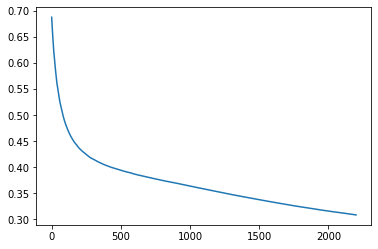

In [9]:
plot(model.evals_result_['learn']['Logloss'])

<AxesSubplot:>

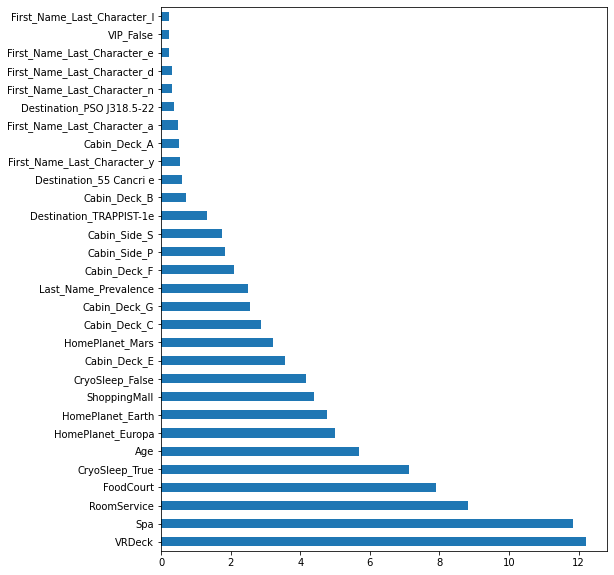

In [10]:
importance = Series(model.feature_importances_, index=x_df.columns)
importance.nlargest(30).plot(kind='barh', figsize=(8,10))

In [11]:
submission_df = read_csv('../input/spaceship-titanic/test.csv')
ids = submission_df['PassengerId'].values
submission_data_df = prepare(input_df=submission_df)
if use_imputer:
    submission_data = imputer.transform(submission_data_df)
else:
    submission_data = submission_data_df.copy(deep=True)
output_df = DataFrame({'PassengerId': ids, 'Transported': model.predict(submission_data) })
output_df.to_csv('submission.csv', index=False)

{'False': 1991, 'True': 2286}

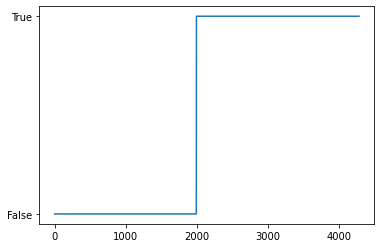

In [12]:
y_pred = model.predict(submission_data)
plot(sorted(y_pred.tolist()), )
values, counts = unique(y_pred, return_counts=True)
dict(zip(values, counts))